<a href="https://www.kaggle.com/code/farruxozodov/prediction-price?scriptVersionId=136622875" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/aviachipta-narxini-bashorat-qilish/train_data.csv
/kaggle/input/aviachipta-narxini-bashorat-qilish/test_data.csv
/kaggle/input/aviachipta-narxini-bashorat-qilish/sample_solution.csv


In [2]:
train = pd.read_csv('../input/aviachipta-narxini-bashorat-qilish/train_data.csv')
test = pd.read_csv('../input/aviachipta-narxini-bashorat-qilish/test_data.csv')
sample_sub = pd.read_csv('../input/aviachipta-narxini-bashorat-qilish/sample_solution.csv')

In [3]:
train.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


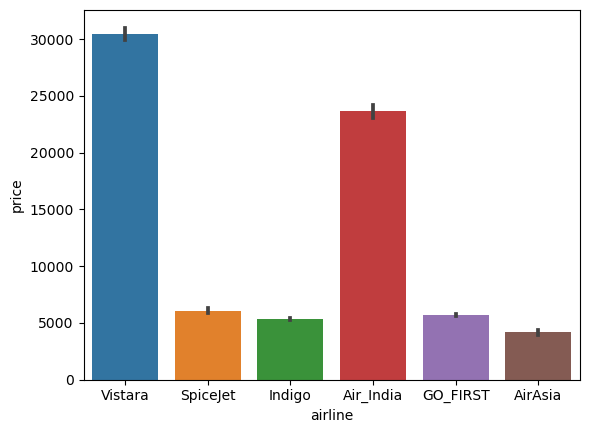

In [5]:
sns.barplot(data=train, x="airline", y="price")
plt.show()

In [6]:
count_by_source = train.groupby('source_city').count()['airline']
source_city = [i for i, df in train.groupby('source_city')]
px.pie(values = count_by_source,names=source_city,color_discrete_sequence=px.colors.sequential.dense,width=600,height=400)

In [7]:
train.airline.value_counts()

Vistara      8535
Air_India    5371
Indigo       2924
GO_FIRST     1508
AirAsia      1056
SpiceJet      606
Name: airline, dtype: int64

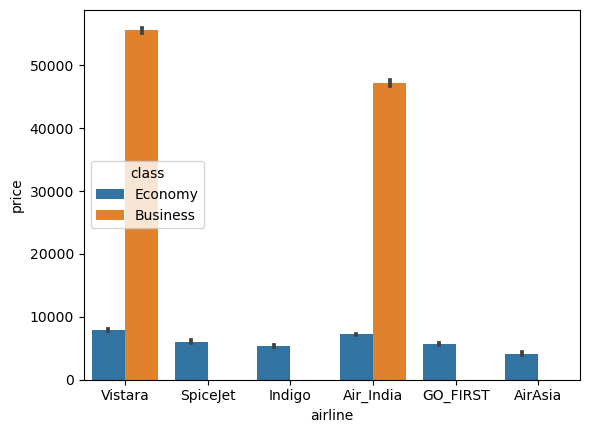

In [8]:
sns.barplot(data=train, x="airline", y="price",  hue="class")
plt.show()

In [9]:
arrival_time = train.groupby('arrival_time').count()['airline']
arrival_time


arrival_time
Afternoon        2536
Early_Morning    1004
Evening          5316
Late_Night        916
Morning          4086
Night            6142
Name: airline, dtype: int64

In [10]:
departure_time=train.groupby('departure_time').count()['airline']
departure_time

departure_time
Afternoon        3166
Early_Morning    4432
Evening          4341
Late_Night         92
Morning          4738
Night            3231
Name: airline, dtype: int64

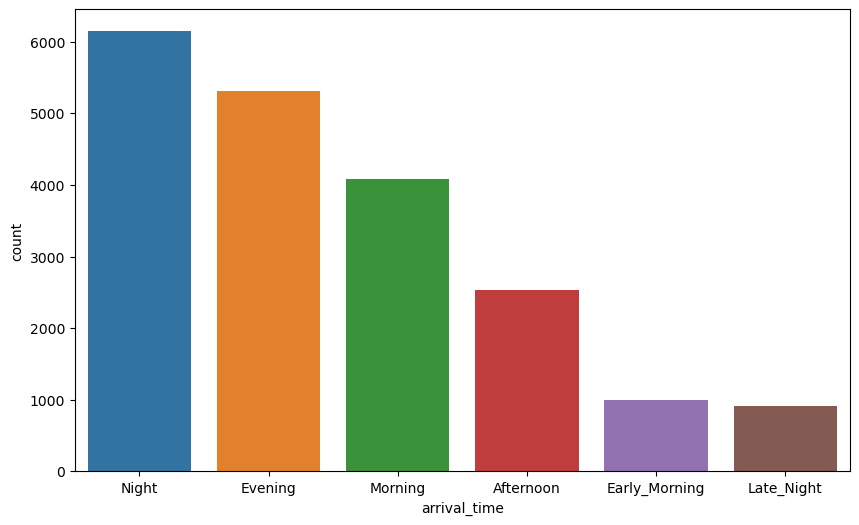

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(x=train["arrival_time"])
plt.show()

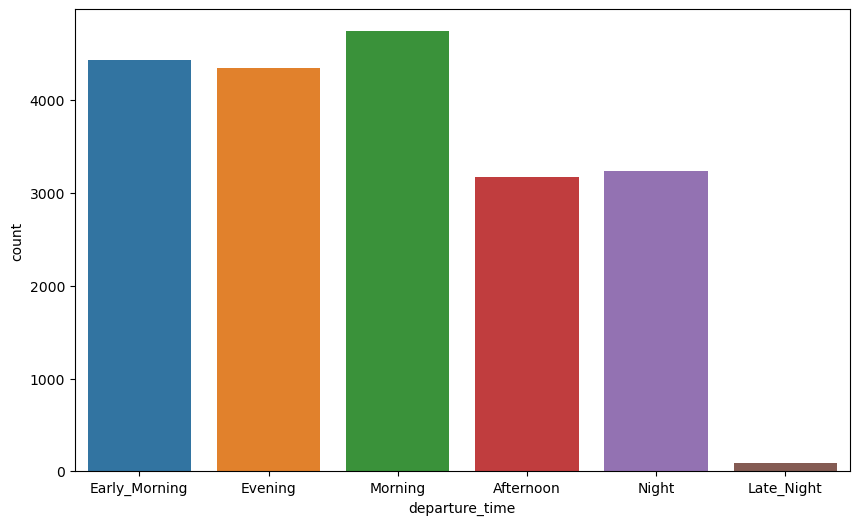

In [12]:
plt.figure(figsize=(10,6))
sns.countplot(x=train["departure_time"])
plt.show()

In [13]:
def preparation_data(data):
    data[['flight_country', 'flight_num']]=data["flight"].str.split("-", expand=True)
    data['flight_num']=data['flight_num'].astype('int64')
    
    encoder = OrdinalEncoder()
    col_ordinal_encoder = data[['flight_country']]
    data[['flight_country']] = encoder.fit_transform(col_ordinal_encoder)
    
    stops = {'one': 0, 'zero': 1, 'two_or_more': 2}
    classes = {'Economy': 0, 'Business': 1}
    data['stops'] = data['stops'].replace(stops)
    data['class'] = data['class'].replace(classes)
    
    one_hot_encoder = ['airline', 'source_city', 'departure_time', 'arrival_time','destination_city']
    data = pd.get_dummies(data, columns=one_hot_encoder)
    
    data.drop(['id','flight'], axis=1, inplace=True)
    return data

In [14]:
train = preparation_data(train)
train.head()

,stops,class,duration,days_left,price,flight_country,flight_num,airline_AirAsia,airline_Air_India,airline_GO_FIRST,...,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0,0,14.25,21,7212,5.0,810,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,1.75,7,5292,4.0,5094,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,1,9.58,5,60553,5.0,846,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,6.75,28,5760,5.0,706,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,2.00,4,10712,0.0,5394,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [15]:
X = train.drop('price', axis=1)
y = train[['price']]

In [16]:
d_tree = DecisionTreeClassifier()
d_tree.fit(X, y)

DecisionTreeClassifier()

In [17]:
test = preparation_data(test)

In [18]:
predictions = d_tree.predict(test)
sample_sub['price']=predictions

In [19]:
sample_sub.to_csv('submission.csv',index=False)

In [20]:
pd.read_csv('submission.csv')

,id,price
0,1,60175
1,2,59033
2,3,23484
3,4,2228
4,5,5102
...,...,...
4995,4996,60978
4996,4997,4499
4997,4998,50271
4998,4999,50868


In [21]:
rfr = RandomForestRegressor()
rfr.fit(X, y)

/tmp/ipykernel_23/1399653781.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor()

In [22]:
predictions = rfr.predict(test)
sample_sub['price']=predictions

In [23]:
sample_sub.to_csv('submission.csv',index=False)